In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
from vips import vipp
from calc_metrics import calc_metrics
import random
from collections import Counter
from tqdm import tqdm

In [2]:
train_fpkm0 = pd.read_csv("../data/BAL/new_counts_fpkm_R.txt",sep='\t').T  #, index_col='sample_id')
train_meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')

In [4]:
train_fpkm0.shape, train_meta.shape

((95, 57785), (95, 32))

### Require X % of samples to have Y gene greater than 0

In [5]:
## Enforce minimum percentage of samples that have > min_count
def check_min_percent(df, min_percent, min_count=0):
    new_cols = []
    for gene in df.columns:
        percent_above_zero = float(len([x for x in df[gene].values if x > min_count]))/len(df[gene].values)*100
        if percent_above_zero >= min_percent:
            new_cols.append(gene)
    return df[new_cols]

In [6]:
train_fpkm = train_fpkm0.apply(lambda x: np.log2(x + 1))

### In this study we have significantly more negative than positive samples
### The function geteven_xy() returns an even number of neg and pos
   - sampling = 'up' means that a random number of pos samples are added to make up the difference (there are duplicate pos. samples)
   - sampling = 'down' means that a random number of neg. samples are removed (there are no duplicates, but the total number of samples is far fewer than when upsampling). 

In [16]:
def get_xy(df, dfm, celltype, norm=False, min_percent=15, min_count=0):
    
    dfm = dfm[dfm['CellType']==celltype]
    
    df = df.ix[dfm.index]
    df = check_min_percent(df, min_percent, min_count)
    
    genes = df.columns
    if norm=='zsc': 
        df = df.apply(lambda x: zscore(x))
    X = np.array(df)
    y = dfm['Pneum'].values
    return X,y, genes, df, dfm

In [10]:
def check_up_or_down(fpkm, meta, celltype, norm, vmin=2.0, cluster=True, min_percent=15, min_count=0):
    
    X, y, genes, df, dfm = get_xy(fpkm, meta, celltype=celltype, 
                                  norm=norm, min_percent=min_percent, min_count=min_count)

    plsv = PLSRegression(5, scale=False)
    plsv.fit(X, y)
    vips = vipp(X, y, plsv.x_scores_, plsv.x_weights_)
    vips = [float(v) for v in vips]
   
    n_highest = len([v for v in vips if v > vmin])
    args_highest = np.argsort(vips)[::-1][:n_highest]
    ensembl_ids = genes[args_highest]
    genes_up = []
    genes_down = []
    pos_samples = dfm[dfm['Pneum']==True].index
    neg_samples = dfm[dfm['Pneum']==False].index
    
    for gene in ensembl_ids:
        mean_up = df.ix[pos_samples][gene].mean()
        mean_down = df.ix[neg_samples][gene].mean()
        if mean_up > mean_down:
            genes_up.append(gene)
        else:
            genes_down.append(gene)
    
    if cluster:
        df_to_plot = df[args_highest]
        print df_to_plot.shape
        plot_cluster(df[args_highest], dfm)
    
    print "N up: {}, N down: {}".format(len(genes_up), len(genes_down))
    return genes_up, genes_down

(49, 665)
N up: 414, N down: 251


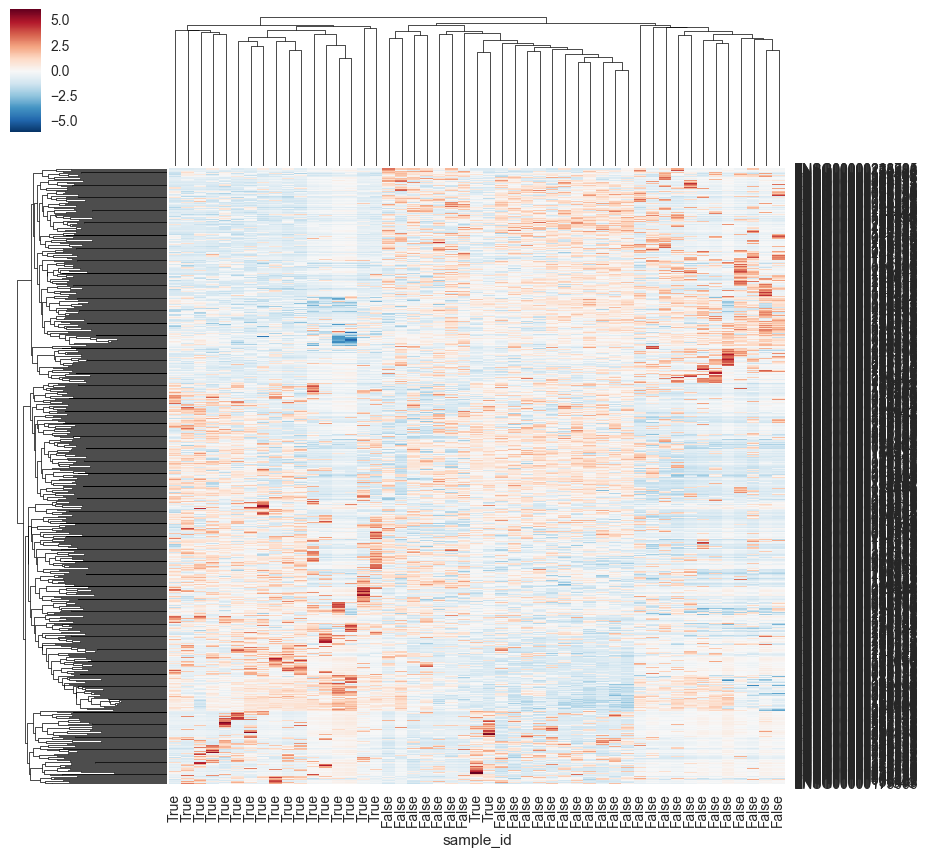

In [24]:
genes_up_AM, genes_down_AM = check_up_or_down(train_fpkm, train_meta, celltype='AM', 
                            norm='zsc', vmin=1.5, min_percent=15, min_count=0)

(46, 1490)
N up: 849, N down: 641


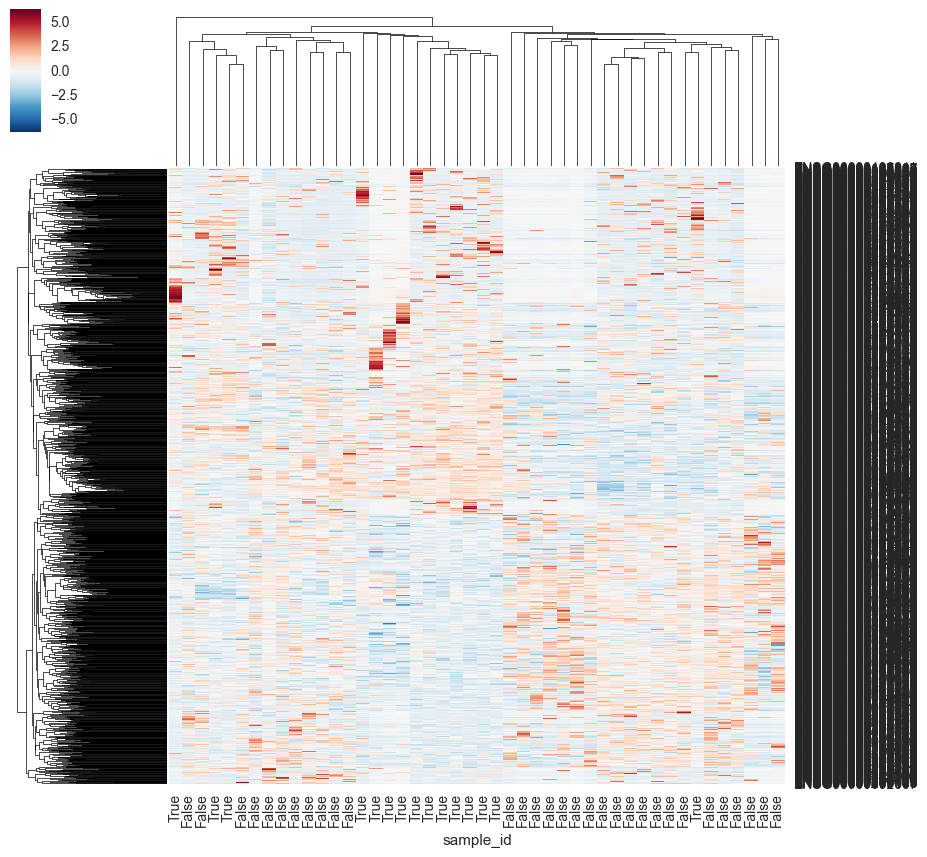

In [25]:
genes_up_AM, genes_down_AM = check_up_or_down(train_fpkm, train_meta, 
                        celltype='CD163', norm='zsc', vmin=1.5, min_percent=15, min_count=0)

(49, 674)
N up: 306, N down: 368


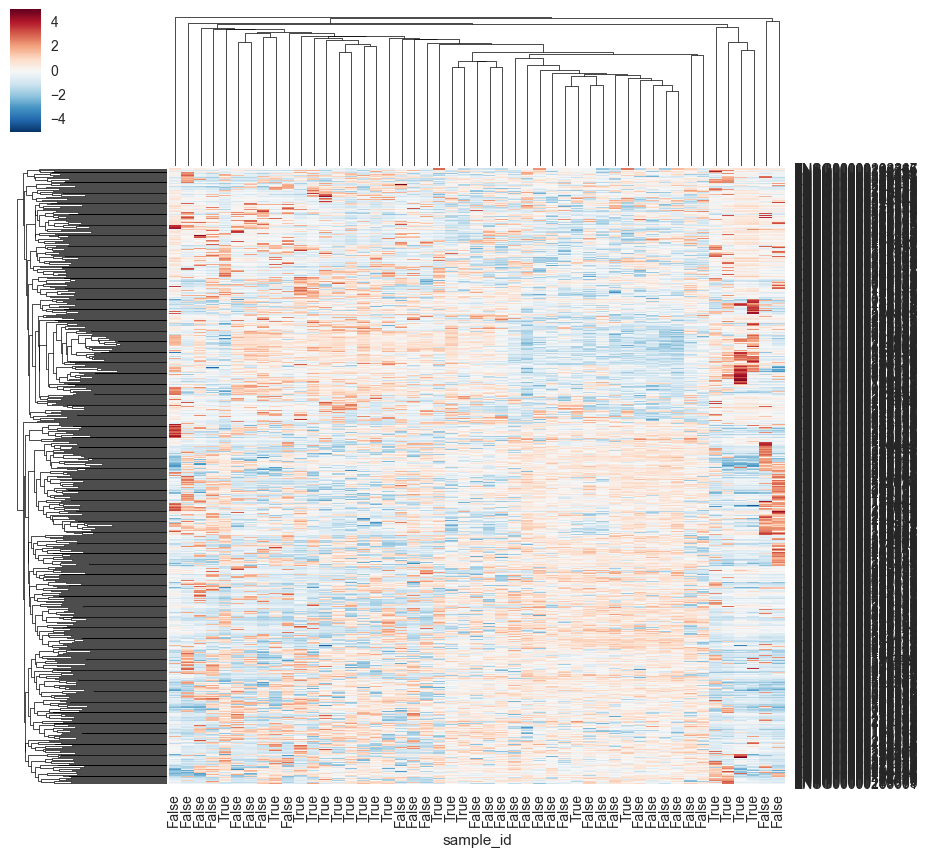

In [20]:
genes_up_AM, genes_down_AM = check_up_or_down(train_fpkm, train_meta, celltype='AM', norm=False, vmin=2, min_percent=15, min_count=0)

(49, 674)
N up: 306, N down: 368


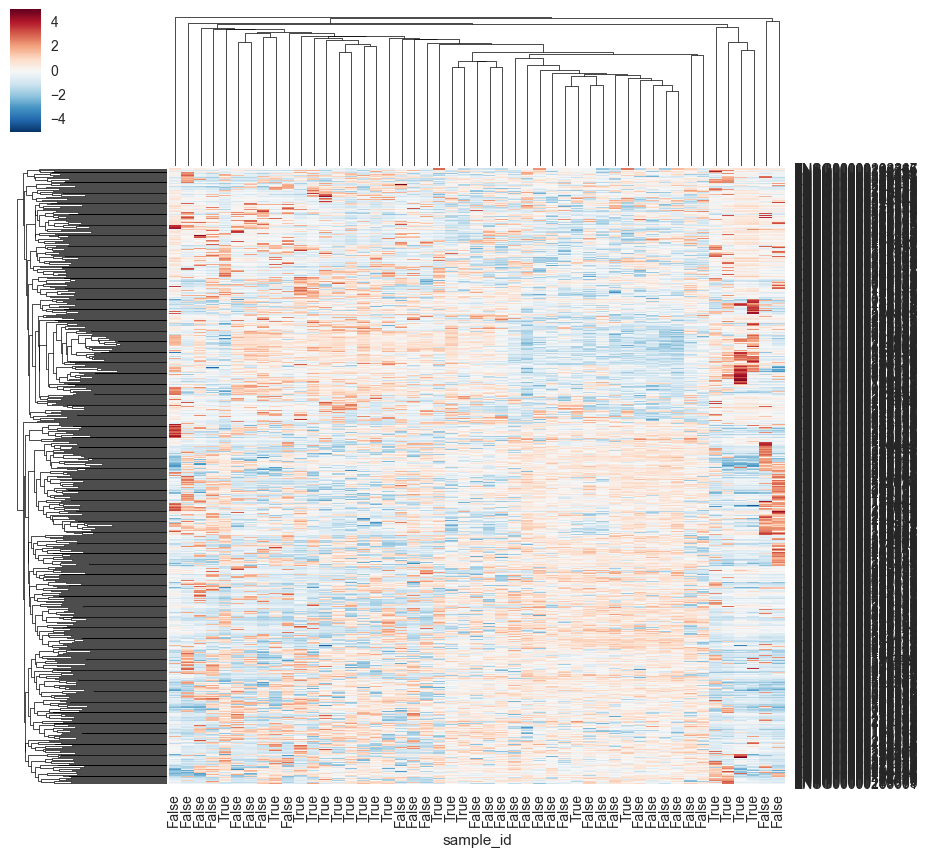

In [19]:
genes_up_AM, genes_down_AM = check_up_or_down(train_fpkm, train_meta, celltype='AM', norm=False, vmin=2, min_percent=80, min_count=0)

(46, 713)
N up: 413, N down: 300


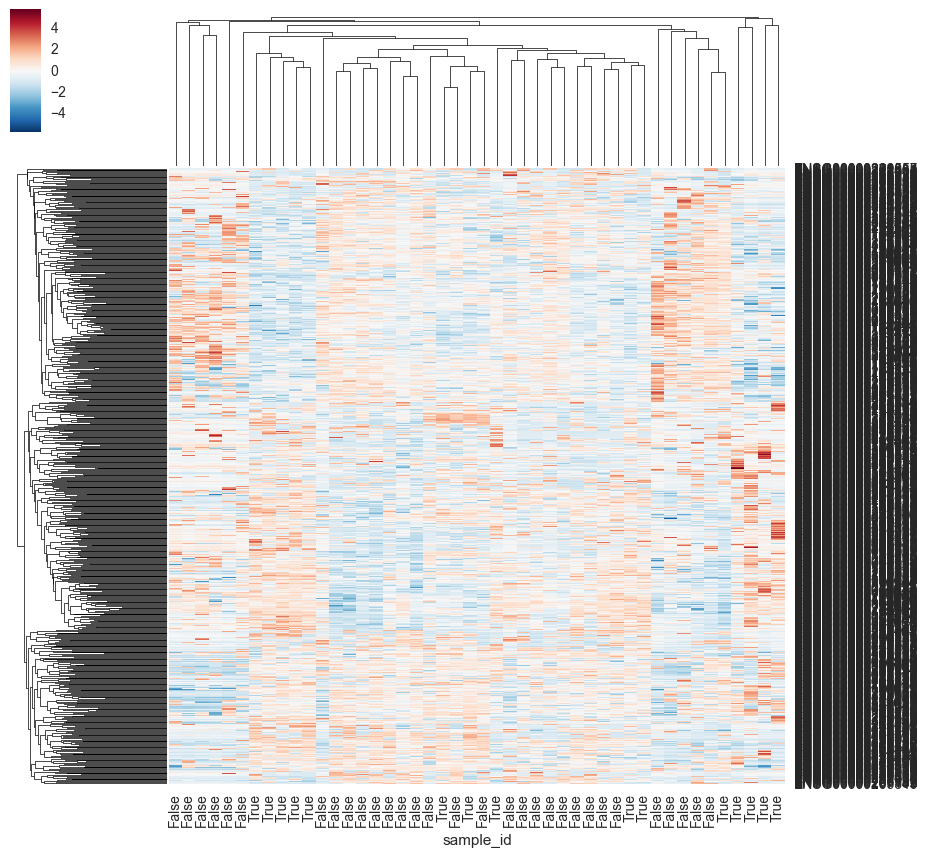

In [13]:
genes_up_163, genes_down_163 = check_up_or_down(train_fpkm, train_meta, celltype='CD163', norm=False, vmin=2)

In [12]:
import seaborn as sns
def plot_cluster(df, dfm):
    
    dfz = df.apply(zscore, axis=1)
    dfz = dfz.apply(zscore, axis=0)
    dfplot = dfz.T

    dfplot = dfplot.rename(columns={c: dfm.loc[c,'Pneum'] for c in dfplot.columns})

    dfplot.columns
    fig = sns.clustermap(dfplot, col_cluster=True)

In [ ]:
cols = np.argsort

# PCA

In [25]:
def get_non_outlier_indices(df, n_stages=1, zcut=2):
    outlier_inds = []
    for i in range(n_stages):
        pca = PCA(n_components=4)
        pca_fit = pca.fit_transform(df)
        pc1, pc2, pc3 = pca_fit.T[0], pca_fit.T[1], pca_fit.T[2]
        z1, z2, z3 = zscore(pc1), zscore(pc2), zscore(pc3)
        #print pc1, z1
        n = len(z1)
        outlier_inds += [i for i in range(n) if abs(z1[i]) > zcut]
        outlier_inds += [i for i in range(n) if abs(z2[i]) > zcut and i not in outlier_inds]
        outlier_inds += [i for i in range(n) if abs(z3[i]) > zcut and i not in outlier_inds]
        for i in range(n):
            if pc1[i] > 20:
                print i, pc1[i], z1[i]
        non_outlier_inds = [i for i in range(n) if i not in outlier_inds]
        print outlier_inds
        df = df.ix[non_outlier_inds,]
    return non_outlier_inds

In [26]:
def plot_pca(counts, meta, celltype, PCs=[1,2], color_label='Pneum', label_pseudomonas=False, 
             label_flu=False, size_col=None, size_scale=100, size_label=True, 
             limits=None, legend_loc='top_right', remove_outliers=False, z_score=True,
             min_gene_count=0, min_uniques=0):
    
    #plt.figure(figsize=(8,6))
    dfm = meta[meta['CellType']==celltype]
    df = counts.ix[dfm.index]
    print df.shape
    colors = {0: 'b', 1: 'orange'} 
    sizes = [size_scale for x in dfm.index]
    
    ### SIZE_COL designates the size of the points
    if size_col: 
        ### IMPUTE NANs by using mean
        dfm[size_col] = dfm[size_col].map(lambda x: np.mean(dfm[size_col]) if np.isnan(x) else x)
        ### Z-SCORE Results
        scores = zscore(dfm[size_col])
        scale = size_scale
        rng = 0.5 ## 50% variation in size
        sizes = [scale + scale*rng*i for i in scores]
    
    ### Run PCA, get labels
    
    ###
    PCi = [x-1 for x in PCs] # PC indices based on input (input PC1 -> PCi=0)
    
    #### Remove outliers
    if remove_outliers != 0:
        print "removing outliers"
        non_outlier_indices = get_non_outlier_indices(df, n_stages=remove_outliers)
        df = df.ix[non_outlier_indices,]
        dfm = dfm.ix[non_outlier_indices,]
        
    if z_score:
        #df = df.apply(zscore, axis=1)
        df = df.apply(zscore, axis=0)

    #### Re-do PCA with outliers removed    

    pca = PCA(n_components=4)
    pca_fit = pca.fit_transform(df)
    pcs = zip(pca_fit.T[PCi[0]], pca_fit.T[PCi[1]])
    
    BALs = df.index
    sample_labels = dfm['Pneum'].values
    
    n_samples = len(pcs)

    ### Color by pneumonia bacteria +/-
    name_dict = {False: 'Negative', True: 'Positive'}#, 'unknown': 'Unknown'}
    labels = name_dict.keys()
    for label in set(labels):
        s = [sizes[i] for i in range(n_samples) if sample_labels[i]==label]
        pc_label = [pcs[i] for i in range(len(pcs)) if sample_labels[i]==label]
        plt.scatter(*zip(*pc_label), color=colors[label], label=name_dict[label], s=s)
        
    ### Label pseudomonas
    pseud_BALs = ['BAL' + str(x) for x in [46, 49, 50, 75, 83]]
    pc_label = [pcs[i] for i in range(n_samples) if BALs[i] in pseud_BALs]
    if label_pseudomonas and len(pc_label) > 0:
        
        plt.scatter(*zip(*pc_label), s=sizes, marker='o', color='r', label='Pseudomonas (Pos.)')
    
    ### Label flu
    flu_BALs = ['BAL' + str(x) for x in [52, 53, 55]]
    pc_label = [pcs[i] for i in range(n_samples) if BALs[i] in flu_BALs]
    s = [sizes[i] for i in range(n_samples) if BALs[i] in flu_BALs]
    if label_flu and len(pc_label) > 0: 
        plt.scatter(*zip(*pc_label), s=s, marker='o', color='m', label='Flu (+Pos.)')
        
    ### Plot PCA
    plt.title('Human ' + celltype + ' Cells, ' + str(df.shape[1]) + ' genes', fontsize=14)
    plt.xlabel('PC {0} \n {1: .1f}% var exp'.format(PCs[0], pca.explained_variance_ratio_[PCi[0]]*100), fontsize=14)
    plt.ylabel('PC {0} \n {1: .1f}% var exp'.format(PCs[1], pca.explained_variance_ratio_[PCi[1]]*100), fontsize=14)
    
    ### Set limits if given
    if limits:
        plt.xlim(limits['x'][0],limits['x'][1])
        plt.ylim(limits['y'][0],limits['y'][1])
        if size_label: 
            plt.text(limits['x'][0]+1, limits['y'][1] - 4, 'Size: ' + size_col, fontsize=12)
    elif size_col and size_label:
        plt.text(0,0, 'Size: ' + size_col, fontsize=8)
    
    ### Fix legend
    loc_dict = {'side': [1.3, 0.5], 'top_right': [1, 1], 'bottom_right': [1, 0.3], 
                'top_left': [0.1, 1], 'bottom_left': [0.1, 0.3]}
    loc = loc_dict[legend_loc]
    #legend = plt.legend(frameon=True)#, bbox_to_anchor=(loc), title = 'Bacterial culture', fontsize=12)
    #frame = legend.get_frame()
    #frame.set_facecolor('white')
    #plt.legend()
    if legend_loc:
        legend = plt.legend(frameon=True, bbox_to_anchor=(loc_dict[legend_loc]))
    else:
        legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    plt.show()

(49, 7927)


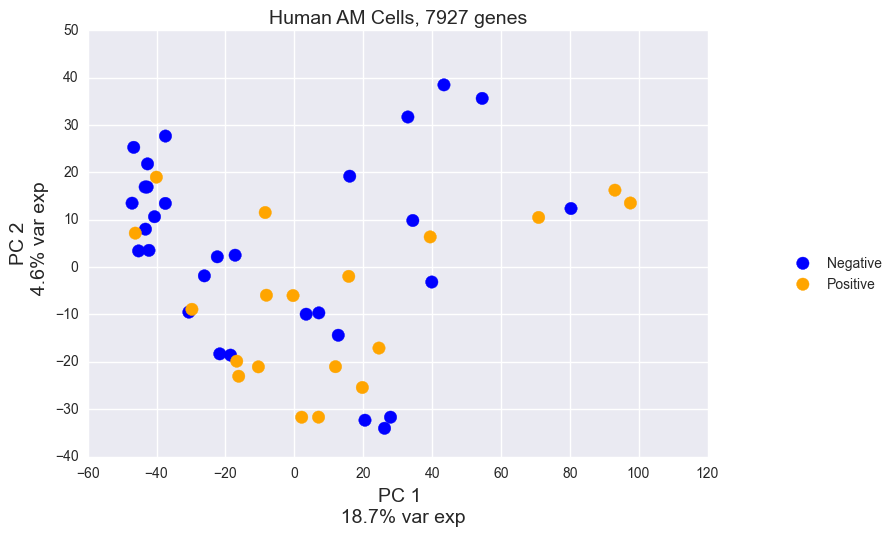

In [41]:
limits = None
plot_pca(train_fpkm, train_meta, celltype='AM', PCs=[1,2], label_pseudomonas=True, 
         label_flu=True,
         size_col=None, size_label=False, size_scale=80,
         limits=limits, legend_loc='side', remove_outliers=0, 
         z_score=True, min_gene_count=10, min_uniques=1e6)


(46, 7927)


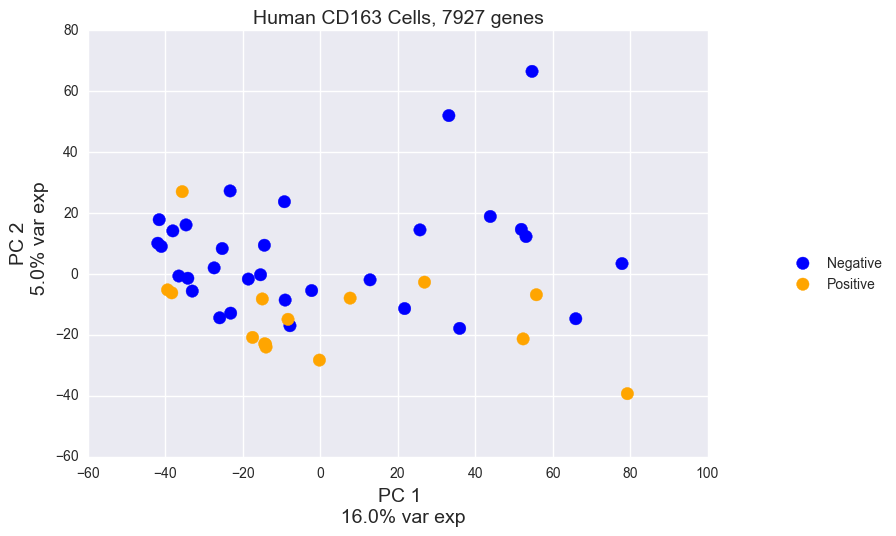

In [39]:
limits = None
plot_pca(train_fpkm, train_meta, celltype='CD163', PCs=[1,2], label_pseudomonas=True, 
         label_flu=True,
         size_col=None, size_label=False, size_scale=80,
         limits=limits, legend_loc='side', remove_outliers=0, 
         z_score=True, min_gene_count=10, min_uniques=1e6)


In [25]:

def get_accuracy_stats(celltype, n_top_genes, norm=False):
    
    
    ### TRAINING
    #################
    
    ## Get most common genes from each model

    X, y, genes, df, dfm = geteven_xy(train_fpkm, meta, celltype=celltype, norm=norm)

    neg_err, pos_err, Q2, neg_accuracy_train, pos_accuracy_train, vip_inds = calc_metrics(X, y, 
                                                        n_pcs=5, n_top_genes=n_top_genes)
    print "Q Squared: {} \n".format(Q2)
    #print "Negative error:"
    #plt.plot(sorted(neg_err))
    #print "Positive error:"
    #plt.plot(sorted(pos_err))

    print "Negative err. avg:{0:.2f}".format(np.mean(neg_err))
    print "Positive err. avg:{0:.2f}\n".format(np.mean(pos_err))
    print "Negative training acc: {0:.2f}".format(neg_accuracy_train)
    print "Positive training acc: {0:.2f}".format(pos_accuracy_train)    
    all_vips = [g for m in vip_inds for g in m]
    c = Counter(all_vips)
    #return c
    top_inds = [i[0] for i in c.most_common(n_top_genes)]
    top_genes_train = [genes[i] for i in top_inds]
    ### Build model based on those genes
    pls = PLSRegression(5, scale=True)
    X_train = np.array(df[top_genes_train])
    #X_train = np.array(df.ix[:,100:200])
    y_train = np.array(dfm['Pneum'])
    pls.fit(X_train, y_train)
    y_train_pred = pls.predict(X_train)
    
    ### TESTING
    ###############
    
    X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(old_fpkm, 
                        old_meta, celltype=celltype, norm=norm)

    X_test = np.array(df_test[top_genes_train])
    #X_test = np.array(df_test.ix[:,100:200])
    y_pred = pls.predict(X_test)

    neg_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==0]
    #print "Negative error: ", neg_err
    neg_accuracy_test = float(sum([(e < 0.5) for e in neg_err])) / len(neg_err)
    print "Negative test acc: {0:.2f} ".format(neg_accuracy_test)
    print "Negative test fraction: {}/{}".format(sum([(e < 0.5) for e in neg_err]), len(neg_err))
    pos_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==1]
    #print "Positive error: ", pos_err
    pos_accuracy_test = float(sum([(e < 0.5) for e in pos_err])) / len(pos_err)
    print "Positive test acc: {0:.2f}".format(pos_accuracy_test)
    #print "positive error mean= {}".format(np.mean(pos_err))
    #print "negative error mean= {}".format(np.mean(neg_err))
    
    return neg_accuracy_train, neg_accuracy_test, pos_accuracy_train, pos_accuracy_test

### testAM = get_accuracy_stats(celltype='AM', n_top_genes=20, norm='zsc')


In [21]:
def calc_metrics(X, y, n_pcs, n_top_genes):
    
    n_samples = len(X)
    pred = []
    vip_inds_all = []
    #print X.shape, y.shape
    
    ### Leave-One-Out Cross-validation
    
    for sample in range(n_samples):
        samples = range(n_samples)
        samples.remove(sample)
        X_t = X[(samples)]
        y_t = y[(samples)]
        #print X_t.shape    
        
        ### Get VIPs for model built without the LOO sample
        plsv = PLSRegression(5, scale=False)
        plsv.fit(X_t, y_t)
        vips = vipp(X_t, y_t, plsv.x_scores_, plsv.x_weights_)
        vips = [float(v) for v in vips]
        vip_inds = np.argsort(vips)[::-1][:n_top_genes]
        vip_inds_all.append(vip_inds)
        
        ### Xn takes the original X to get the loo sample
        Xn = X.T[vip_inds].T
        loo_sample = Xn[sample]
        loo_sample = np.array(loo_sample).reshape((1, -1))
        
        ### Filter the samples 
        X_tn = X_t.T[vip_inds].T
        #print X_tn.shape
        pls = PLSRegression(n_pcs, scale=False)
        pls.fit(X_tn, y_t)

        pred.append(float(pls.predict(loo_sample)))

    # Calculate metrics
    ### Q squared
    num = sum([float((pred[i] - y[i]))**2 for i in range(len(pred))])
    den = sum([(y[i] - np.mean(y))**2 for i in range(len(pred))])
    Q2 = float(1 - num/den)

    ### Prediction error
    errs = [abs(float((pred[i] - y[i]))) for i in range(len(pred))]
 
    ### Percent correct for neg and pos Pneumonia
    neg_err = [errs[i] for i in range(len(errs)) if y[i]==0]  
    neg_corr = [e < 0.5 for e in neg_err]   
    neg_corr = float(sum(neg_corr)) / len(neg_err)

    
    pos_err = [errs[i] for i in range(len(errs)) if y[i]==1]
    pos_corr = [e < 0.5 for e in pos_err]
    pos_corr = float(sum(pos_corr)) / len(pos_err)
    

    #print "num: {0: .3f}, den: {1: .3f}, 
    #print "Q^2: {0: .3f}".format(Q2)
    
    return neg_err, pos_err, Q2, neg_corr, pos_corr, vip_inds_all
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]

In [20]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [75]:
def calc_Q2_kfold(X, y, k=5, n_rand=10, n_pcs=5, method='PLSR'):
    n_samples = len(X)
    pred = []
    Q2s = []
    for ki in range(n_rand):
        sample_ind = range(n_samples)
        withheld_samples = random.sample(sample_ind, k)
        lo_samples = X[withheld_samples]
        for s in withheld_samples:
            sample_ind.remove(s)
        X_t = X[(sample_ind)]
        y_t = y[(sample_ind)]
        if method=='PLSR':
            model = PLSRegression(n_pcs, scale=False)
        elif method=='RF':
            model = RandomForestClassifier()
        elif method=='SVM':
            model = SVC()
        else:
            print "Method not found"
        model.fit(X_t, y_t)

        for s in withheld_samples:
            pred.append(float(model.predict(X[s])))
        #Eprint "samples", withheld_samples
        #Eprint "pred", pred
        num = sum([(pred[i] - y[s])**2 for i, s in enumerate(withheld_samples)])
        den = sum([(y[s] - np.mean(y[withheld_samples]))**2 for s in withheld_samples])
        Q2 = float(1- num/den)
        Q2s.append(Q2)
    print "Q^2: mean={0: .2f}, std={1: .2f}".format(np.mean(Q2s),np.std(Q2s))
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]

In [96]:
with open("163_up_genes.txt", 'w') as f:
    for gene in genes_up_163:
        print>>f, gene

In [97]:
with open("163_down_genes.txt", 'w') as f:
    for gene in genes_down_163:
        print>>f, gene

In [85]:
with open("AM_up_genes.txt", 'w') as f:
    for gene in genes_up_AM:
        print>>f, gene

In [86]:
with open("AM_down_genes.txt", 'w') as f:
    for gene in genes_down_AM:
        print>>f, gene